In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Preprocess for the drug response data.
- Removes outliers by filtering out data points where HI_CONCENTRATION is greater than or equal to 1
- Integrates the data with Drug-Target Interaction (DTI) information, keeping only the drugs that have corresponding DTI data

# Dataset from NCI60 [Link](https://wiki.nci.nih.gov/display/ncidtpdata/nci-60+growth+inhibition+data)

In [2]:
df = pd.read_csv(
    "../data/IC50.zip",
    usecols=["NSC", "CONCENTRATION_UNIT", "LOG_HI_CONCENTRATION", "CELL_NAME", "COUNT"],
)

In [3]:
df

,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,CELL_NAME,COUNT
0,123127,M,-4.6021,UACC-62,1
1,123127,M,-4.6021,UACC-257,1
2,123127,M,-4.6021,PC-3,1
3,123127,M,-4.6021,SNB-19,1
4,123127,M,-4.6021,HT29,1
...,...,...,...,...,...
4698873,777571,M,-4.0000,UACC-257,1
4698874,777571,M,-4.0000,SNB-75,1
4698875,777571,M,-4.0000,HCT-116,1
4698876,777571,M,-4.0000,BT-549,1


In [4]:
df["HI_CONCENTRATION"] = 10 ** df["LOG_HI_CONCENTRATION"]

In [5]:
print("max", np.max(df["HI_CONCENTRATION"]))
print("min", np.min(df["HI_CONCENTRATION"]))
print("mean", np.mean(df["HI_CONCENTRATION"]))
print("median", np.median(df["HI_CONCENTRATION"]))

max 10000.0
min 1.9998618696327447e-13
mean 2.0112505520193946
median 0.0001


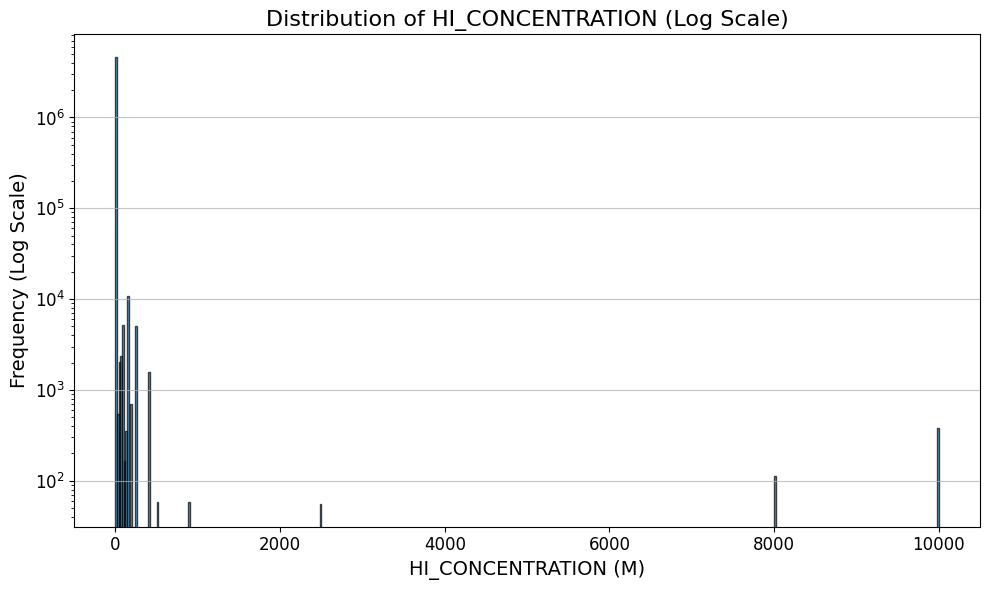

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df["HI_CONCENTRATION"], bins=500, edgecolor="black", alpha=0.7)
plt.yscale("log")
plt.title("Distribution of HI_CONCENTRATION (Log Scale)", fontsize=16)
plt.xlabel("HI_CONCENTRATION (M)", fontsize=14)
plt.ylabel("Frequency (Log Scale)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()

In [7]:
len(df["CELL_NAME"].unique())

159

In [8]:
name_map = {
    "UACC-62": "UACC_62",
    "UACC-257": "UACC_257",
    "PC-3": "PC_3",
    "SNB-19": "SNB_19",
    "HT29": "HT29",
    "MCF7": "MCF7",
    "IGROV1": "IGROV1",
    "SK-OV-3": "SK_OV_3",
    "A498": "A498",
    "NCI-H322M": "NCI_H322M",
    "SF-268": "SF_268",
    "COLO 205": "COLO205",
    "MDA-N": "MDA_N",
    "HL-60(TB)": "HL_60",
    "RXF 393": "RXF_393",
    "TK-10": "TK_10",
    "SK-MEL-2": "SK_MEL_2",
    "SF-539": "SF_539",
    "KM12": "KM12",
    "OVCAR-3": "OVCAR_3",
    "HOP-92": "HOP_92",
    "NCI-H522": "NCI_H522",
    "EKVX": "EKVX",
    "M14": "M14",
    "SNB-75": "SNB_75",
    "HCT-116": "HCT_116",
    "OVCAR-8": "OVCAR_8",
    "NCI-H23": "NCI_H23",
    "T-47D": "T47D",
    "NCI/ADR-RES": "NCI_ADR_RES",
    "MOLT-4": "MOLT_4",
    "SK-MEL-5": "SK_MEL_5",
    "HCT-15": "HCT_15",
    "OVCAR-5": "OVCAR_5",
    "RPMI-8226": "RPMI_8226",
    "NCI-H226": "NCI_H226",
    "DU-145": "DU_145",
    "ACHN": "ACHN",
    "UO-31": "UO_31",
    "SN12C": "SN12C",
    "HCC-2998": "HCC_2998",
    "K-562": "K_562",
    "A549/ATCC": "A549",
    "SW-620": "SW_620",
    "OVCAR-4": "OVCAR_4",
    "CAKI-1": "CAKI_1",
    "786-0": "786_0",
    "CCRF-CEM": "CCRF_CEM",
    "NCI-H460": "NCI_H460",
    "U251": "U251",
    "MDA-MB-435": "MDA_MB_435",
    "HS 578T": "HS578T",
    "HOP-62": "HOP_62",
    "MALME-3M": "MALME_3M",
    "MDA-MB-231/ATCC": "MDA_MB_231",
    "SK-MEL-28": "SK_MEL_28",
    "BT-549": "BT_549",
    "SF-295": "SF_295",
    "LOX IMVI": "LOXIMVI",
    "SR": "SR",
    "NYH/ICRF-187-1": "NYH",
    "MDA-MB-468": "MDA_MB_468",
    "U-87/H.Fine": "U_87/H_Fine",
    "U-251/H.Fine": "U_251/H_Fine",
    "T98G/H.Fine": "T98G/H_Fine",
    "U118/H.Fine": "U118/H_Fine",
    "U-373/H.Fine": "U_373/H_Fine",
    "A-172/H.Fine": "A_172/H_Fine",
    "LN-229/H.Fine": "LN_229/H_Fine",
    "NYH": "NYH",
    "CHO": "CHO",
    "CHO/159-1": "CHO_159_1",
    "HOP-18": "HOP_18",
    "SN12K1": "SN12K1",
    "XF 498": "XF_498",
    "M19-MEL": "M19_MEL",
    "KM20L2": "KM20L2",
    "P388/ADR": "P388_ADR",
    "SNB-78": "SNB_78",
    "DLD-1": "DLD_1",
    "P388": "P388",
    "DMS 114": "DMS_114",
    "DMS 273": "DMS_273",
    "TK-164": "TK_164",
    "SW-156": "SW_156",
    "LXFL 529": "LXFL_529",
    "HT": "HT",
    "DB": "DB",
    "RL": "RL",
    "RXF-631": "RXF_631",
    "MEXF 514L": "MEXF_514L",
    "SW-1573": "SW_1573",
    "CXF 264L": "CXF_264L",
    "UISO-BCA-1": "UISO_BCA_1",
    "COLO 741": "COLO_741",
    "COLO 746": "COLO_746",
    "SW 1783": "SW_1783",
    "RXF 486L": "RXF_486L",
    "LXFS 650L": "LXFS_650L",
    "SW 1088": "SW_1088",
    "RPMI-7951": "RPMI_7951",
    "MLI-019": "MLI_019",
    "SF-767": "SF_767",
    "UOK-57": "UOK_57",
    "UABMEL3": "UABMEL3",
    "MLI-076": "MLI_076",
    "MCF7/ATCC": "MCF7",
    "UABLG22": "UABLG22",
    "MLI-045": "MLI_045",
    "CHA-59": "CHA_59",
    "ZR-75-1": "ZR_75_1",
    "SMS-KCNR": "SMS_KCNR",
    "MLI-059": "MLI_059",
    "SK-BR-3": "SK_BR_3",
    "CALU-1": "CALU_1",
    "ZR-75-30": "ZR_75_30",
    "A-204": "A_204",
    "CACO-2": "CACO_2",
    "JCA-1": "JCA_1",
    "ND-1": "ND_1",
    "TSU-PRI": "TSU_PRI",
    "TE85": "TE85",
    "MAXF 401": "MAXF_401",
    "ES-2 CNCR": "ES_2_CNCR",
    "HCT-116/P21/B": "HCT_116_P21_B",
    "HCT-116/P21/C": "HCT_116_P21_C",
    "HCT-116/P": "HCT_116_P",
    "HCT-116/CMV-1": "HCT_116_CMV_1",
    "HCT-116/E6-2": "HCT_116_E6_2",
    "HCT-116/CMV-2": "HCT_116_CMV_2",
    "HCT-116/P21/A": "HCT_116_P21_A",
    "HCT-116/E6-1": "HCT_116_E6_1",
    "HCT-116/PV": "HCT_116_PV",
    "VDSO/CMV-8": "VDSO_CMV_8",
    "VDSO/CMV-9": "VDSO_CMV_9",
    "VDSO/E6-18": "VDSO_E6_18",
    "VDSO/P": "VDSO_P",
    "NB4": "NB4",
    "RKO Waf1": "RKO_Waf1",
    "T47D NFkB15": "T47D_NFkB15",
    "T47D ERE4": "T47D_ERE4",
    "HT29p53RE22": "HT29_p53RE22",
    "H1299p53RE29": "H1299_p53RE29",
    "T47D FOS1": "T47D_FOS1",
    "MCF7-E6": "MCF7_E6",
    "RKOp53RE1": "RKO_p53RE1",
    "A-C/EBP 3": "A_C_EBP_3",
    "A-JUN 1": "A_JUN_1",
    "A-JUN 3": "A_JUN_3",
    "A-FOS 2": "A_FOS_2",
    "WI-38": "WI_38",
    "CCD-19LU": "CCD_19LU",
    "VDSO/E6-19": "VDSO_E6_19",
    "A-CREB 1": "A_CREB_1",
    "A-FOS 3": "A_FOS_3",
    "A431": "A431",
    "A-CREB 2": "A_CREB_2",
    "MDA-MB-435S": "MDA_MB_435S",
    "Mar-Bel": "Mar_Bel",
}

In [9]:
cols = pd.read_csv("../data/nci60_gene_exp.csv", index_col=0).columns
cols

Index(['MCF7', 'MDA_MB_231', 'HS578T', 'BT_549', 'T47D', 'SF_268', 'SF_295',
       'SF_539', 'SNB_19', 'SNB_75', 'U251', 'COLO205', 'HCC_2998', 'HCT_116',
       'HCT_15', 'HT29', 'KM12', 'SW_620', 'CCRF_CEM', 'HL_60', 'K_562',
       'MOLT_4', 'RPMI_8226', 'SR', 'LOXIMVI', 'MALME_3M', 'M14', 'SK_MEL_2',
       'SK_MEL_28', 'SK_MEL_5', 'UACC_257', 'UACC_62', 'MDA_MB_435', 'MDA_N',
       'A549', 'EKVX', 'HOP_62', 'HOP_92', 'NCI_H226', 'NCI_H23', 'NCI_H322M',
       'NCI_H460', 'NCI_H522', 'IGROV1', 'OVCAR_3', 'OVCAR_4', 'OVCAR_5',
       'OVCAR_8', 'SK_OV_3', 'NCI_ADR_RES', 'PC_3', 'DU_145', '786_0', 'A498',
       'ACHN', 'CAKI_1', 'RXF_393', 'SN12C', 'TK_10', 'UO_31'],
      dtype='object')

In [10]:
df["CELL_NAME_nci"] = [name_map[i] for i in df["CELL_NAME"]]
df

,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,CELL_NAME,COUNT,HI_CONCENTRATION,CELL_NAME_nci
0,123127,M,-4.6021,UACC-62,1,0.000025,UACC_62
1,123127,M,-4.6021,UACC-257,1,0.000025,UACC_257
2,123127,M,-4.6021,PC-3,1,0.000025,PC_3
3,123127,M,-4.6021,SNB-19,1,0.000025,SNB_19
4,123127,M,-4.6021,HT29,1,0.000025,HT29
...,...,...,...,...,...,...,...
4698873,777571,M,-4.0000,UACC-257,1,0.000100,UACC_257
4698874,777571,M,-4.0000,SNB-75,1,0.000100,SNB_75
4698875,777571,M,-4.0000,HCT-116,1,0.000100,HCT_116
4698876,777571,M,-4.0000,BT-549,1,0.000100,BT_549


In [11]:
df = df[df.CELL_NAME_nci.isin(cols)]
df

,NSC,CONCENTRATION_UNIT,LOG_HI_CONCENTRATION,CELL_NAME,COUNT,HI_CONCENTRATION,CELL_NAME_nci
0,123127,M,-4.6021,UACC-62,1,0.000025,UACC_62
1,123127,M,-4.6021,UACC-257,1,0.000025,UACC_257
2,123127,M,-4.6021,PC-3,1,0.000025,PC_3
3,123127,M,-4.6021,SNB-19,1,0.000025,SNB_19
4,123127,M,-4.6021,HT29,1,0.000025,HT29
...,...,...,...,...,...,...,...
4698873,777571,M,-4.0000,UACC-257,1,0.000100,UACC_257
4698874,777571,M,-4.0000,SNB-75,1,0.000100,SNB_75
4698875,777571,M,-4.0000,HCT-116,1,0.000100,HCT_116
4698876,777571,M,-4.0000,BT-549,1,0.000100,BT_549


In [12]:
print("max", np.max(df["HI_CONCENTRATION"]))
print("min", np.min(df["HI_CONCENTRATION"]))
print("mean", np.mean(df["HI_CONCENTRATION"]))
print("median", np.median(df["HI_CONCENTRATION"]))

max 10000.0
min 1.9998618696327447e-13
mean 1.840003216832726
median 0.0001


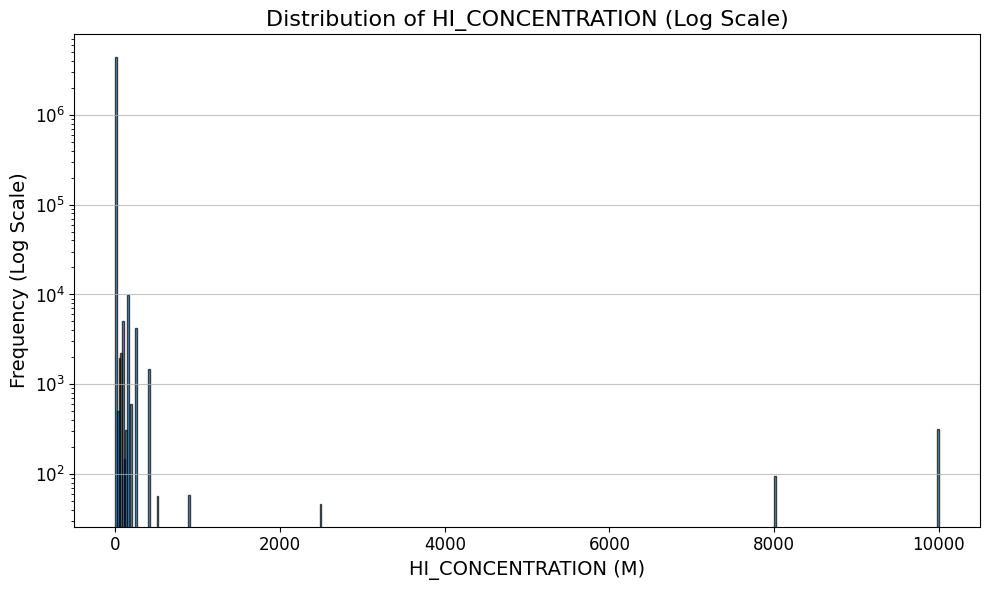

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df["HI_CONCENTRATION"], bins=500, edgecolor="black", alpha=0.7)
plt.yscale("log")
plt.title("Distribution of HI_CONCENTRATION (Log Scale)", fontsize=16)
plt.xlabel("HI_CONCENTRATION (M)", fontsize=14)
plt.ylabel("Frequency (Log Scale)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()

In [14]:
df = df[["NSC", "HI_CONCENTRATION", "CELL_NAME_nci"]]
df = df.drop_duplicates().reset_index(drop=True)
df

,NSC,HI_CONCENTRATION,CELL_NAME_nci
0,123127,0.000025,UACC_62
1,123127,0.000025,UACC_257
2,123127,0.000025,PC_3
3,123127,0.000025,SNB_19
4,123127,0.000025,HT29
...,...,...,...
3167521,777448,0.000100,EKVX
3167522,775772,0.000100,HL_60
3167523,776786,0.000100,EKVX
3167524,777447,0.000100,EKVX


In [15]:
t = df.groupby(["NSC", "CELL_NAME_nci"]).agg("mean")
t = t.reset_index()
t

,NSC,CELL_NAME_nci,HI_CONCENTRATION
0,1,786_0,0.00055
1,1,A498,0.00055
2,1,A549,0.00055
3,1,ACHN,0.00055
4,1,BT_549,0.00055
...,...,...,...
3103538,849222,T47D,0.00010
3103539,849222,TK_10,0.00010
3103540,849222,U251,0.00010
3103541,849222,UACC_257,0.00010


In [16]:
t["HI_CONCENTRATION"].describe()

count    3.103543e+06
mean     1.801936e+00
std      1.017846e+02
min      1.000000e-10
25%      1.000000e-04
50%      1.000000e-04
75%      1.000000e-04
max      1.000000e+04
Name: HI_CONCENTRATION, dtype: float64

# Choose drugs which have NSCs

In [17]:
drug_nscs = torch.load("../data/drug_list.pt")
drug_nscs

[2,
 4,
 5,
 8,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 19,
 34,
 43,
 46,
 55,
 60,
 61,
 81,
 83,
 85,
 88,
 91,
 92,
 96,
 98,
 100,
 111,
 120,
 121,
 132,
 133,
 135,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 147,
 149,
 163,
 165,
 166,
 167,
 171,
 173,
 176,
 177,
 178,
 179,
 180,
 183,
 185,
 186,
 189,
 217,
 218,
 232,
 236,
 241,
 247,
 252,
 257,
 264,
 267,
 271,
 272,
 274,
 277,
 278,
 282,
 285,
 286,
 287,
 295,
 301,
 302,
 303,
 311,
 313,
 316,
 325,
 326,
 334,
 335,
 336,
 338,
 345,
 346,
 354,
 362,
 378,
 379,
 380,
 386,
 398,
 399,
 400,
 402,
 403,
 405,
 406,
 410,
 411,
 420,
 427,
 428,
 430,
 431,
 432,
 434,
 435,
 437,
 438,
 439,
 441,
 443,
 444,
 446,
 450,
 451,
 452,
 454,
 455,
 456,
 458,
 460,
 461,
 462,
 464,
 465,
 473,
 474,
 475,
 478,
 487,
 490,
 495,
 508,
 511,
 512,
 516,
 519,
 523,
 524,
 537,
 541,
 542,
 552,
 553,
 554,
 562,
 567,
 575,
 579,
 585,
 589,
 594,
 598,
 607,
 614,
 615,
 618,
 620,
 623,
 629,
 630,
 631,
 632

In [18]:
t = t[t.NSC.isin(drug_nscs)]
t

,NSC,CELL_NAME_nci,HI_CONCENTRATION
0,1,786_0,0.00055
1,1,A498,0.00055
2,1,A549,0.00055
3,1,ACHN,0.00055
4,1,BT_549,0.00055
...,...,...,...
3103538,849222,T47D,0.00010
3103539,849222,TK_10,0.00010
3103540,849222,U251,0.00010
3103541,849222,UACC_257,0.00010


# Choose drugs which have DTIs

In [19]:
genes = pd.read_csv("../data/genes.csv").T
dti = pd.read_csv("../../DTI-quantification/data/drug_gene_score.csv.gz")
dti = dti[dti.gene.isin(list(genes.index))][["gene", "NSC", "log_Y"]].dropna()
dti_nscs = sorted(set(dti.NSC))

In [20]:
t = t[t.NSC.isin(dti_nscs)]
t

,NSC,CELL_NAME_nci,HI_CONCENTRATION
59,17,786_0,0.0001
60,17,A498,0.0001
61,17,A549,0.0001
62,17,ACHN,0.0001
63,17,BT_549,0.0001
...,...,...,...
3103538,849222,T47D,0.0001
3103539,849222,TK_10,0.0001
3103540,849222,U251,0.0001
3103541,849222,UACC_257,0.0001


# Removing outliers

In [21]:
t = t[t["HI_CONCENTRATION"] < 1].reset_index(drop=True)
t

,NSC,CELL_NAME_nci,HI_CONCENTRATION
0,17,786_0,0.0001
1,17,A498,0.0001
2,17,A549,0.0001
3,17,ACHN,0.0001
4,17,BT_549,0.0001
...,...,...,...
219999,849222,T47D,0.0001
220000,849222,TK_10,0.0001
220001,849222,U251,0.0001
220002,849222,UACC_257,0.0001


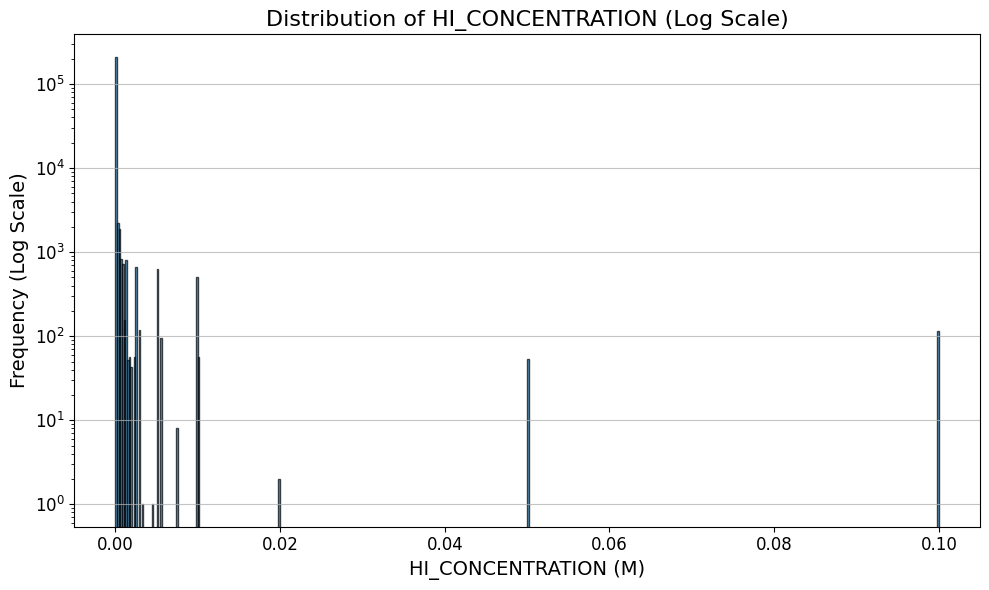

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(t["HI_CONCENTRATION"], bins=500, edgecolor="black", alpha=0.7)
plt.yscale("log")
plt.title("Distribution of HI_CONCENTRATION (Log Scale)", fontsize=16)
plt.xlabel("HI_CONCENTRATION (M)", fontsize=14)
plt.ylabel("Frequency (Log Scale)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()

# Only data which has a DTI

In [23]:
genes = pd.read_csv("../data/genes.csv").T
dti = pd.read_csv("../../DTI-quantification/data/drug_gene_score.csv.gz")
dti = dti[dti.gene.isin(list(genes.index))]["NSC"].unique()
dti

array([  3188.,   6292.,  14580., ..., 842116., 852991., 841442.])

In [24]:
t = t[t.NSC.isin(dti)]
t

,NSC,CELL_NAME_nci,HI_CONCENTRATION
0,17,786_0,0.0001
1,17,A498,0.0001
2,17,A549,0.0001
3,17,ACHN,0.0001
4,17,BT_549,0.0001
...,...,...,...
219999,849222,T47D,0.0001
220000,849222,TK_10,0.0001
220001,849222,U251,0.0001
220002,849222,UACC_257,0.0001


In [25]:
t.to_csv("../data/dataset.csv")